# World Wide Products Inc.
## General Info
Author: Patrick McNamee

Date: 10/2/2019

## Description
Using a [dataset](https://www.kaggle.com/felixzhao/productdemandforecasting) from Kaggle to attempt to forcast product demand for an anonymous product.

## Data Acquisition and Cleaning
First thing to do is load in the original data set and take a look

In [1]:
import pandas as pd

df = pd.read_csv(r'./data/Historical Product Demand.csv')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


The most numerous ordered product is Product_1359 according to Kaggle and so I will look only at that product.

In [2]:
df = df.loc[df['Product_Code'] == 'Product_1359']
df = df.reset_index(drop=True)
df.tail()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
16931,Product_1359,Whse_J,Category_019,2016/10/3,20000
16932,Product_1359,Whse_J,Category_019,2016/9/16,10000
16933,Product_1359,Whse_J,Category_019,2016/11/1,30000
16934,Product_1359,Whse_J,Category_019,2016/12/1,20000
16935,Product_1359,Whse_J,Category_019,2016/12/9,20000


So Product_1359 has been isolated although it has a lot of entries but we are still seeing the same values for the Product_Category as well as Warehouse. I will check to see if there are multiple unique values in these columns. If there is only one value, I will remove them as there is no additional information from those columns.

In [3]:
print(df['Warehouse'].unique())

['Whse_J']


In [4]:
print(df['Product_Category'].unique())

['Category_019']


In [5]:
df = df.drop(['Product_Code', 'Warehouse', 'Product_Category'], axis=1)

There is no NaNs in the dataframe as it would show up in the lists of unique values. I will commit this data to a csv for easier access later on. However, first I need to do some type conversion to numerically manipulate the information.

In [6]:
df['Date'] = pd.to_datetime(df['Date'])#converting over to date time

In [7]:
df['Order_Demand'].unique()

array(['80000 ', '70000 ', '100000 ', '84000 ', '1000 ', '15000 ',
       '30000 ', '10000 ', '28000 ', '5000 ', '6000 ', '21000 ', '2000 ',
       '3000 ', '50000 ', '75000 ', '20000 ', '750000 ', '225000 ',
       '300000 ', '150000 ', '525000 ', '375000 ', '11000 ', '14000 ',
       '39000 ', '25000 ', '12000 ', '35000 ', '13000 ', '60000 ',
       '7000 ', '34000 ', '8000 ', '9000 ', '36000 ', '16000 ', '18000 ',
       '4000 ', '17000 ', '56000 ', '54000 ', '63000 ', '85000 ',
       '37000 ', '65000 ', '59000 ', '66000 ', '72000 ', '43000 ',
       '51000 ', '134000 ', '61000 ', '155000 ', '74000 ', '266000 ',
       '88000 ', '90000 ', '223000 ', '120000 ', '101000 ', '139000 ',
       '222000 ', '26000 ', '121000 ', '27000 ', '234000 ', '149000 ',
       '118000 ', '98000 ', '78000 ', '52000 ', '200000 ', '40000 ',
       '400000 ', '1000000 ', '700000 ', '740000 ', '130000 ', '500000 ',
       '550000 ', '19000 ', '22000 ', '112000 ', '105000 ', '29000 ',
       '31000 ', '450

In [8]:
#Loop to remove parenthesis from numbers
for i in range(len(df)):
    date = df.iat[i, 1]
    if date[0] == '(':
        date = date[1:-2]
        df.iat[i,1] = date
#Type conversion to int
df['Order_Demand'] = df['Order_Demand'].astype('int32')
df['Order_Demand'].unique()

array([  80000,   70000,  100000,   84000,    1000,   15000,   30000,
         10000,   28000,    5000,    6000,   21000,    2000,    3000,
         50000,   75000,   20000,  750000,  225000,  300000,  150000,
        525000,  375000,   11000,   14000,   39000,   25000,   12000,
         35000,   13000,   60000,    7000,   34000,    8000,    9000,
         36000,   16000,   18000,    4000,   17000,   56000,   54000,
         63000,   85000,   37000,   65000,   59000,   66000,   72000,
         43000,   51000,  134000,   61000,  155000,   74000,  266000,
         88000,   90000,  223000,  120000,  101000,  139000,  222000,
         26000,  121000,   27000,  234000,  149000,  118000,   98000,
         78000,   52000,  200000,   40000,  400000, 1000000,  700000,
        740000,  130000,  500000,  550000,   19000,   22000,  112000,
        105000,   29000,   31000,   45000,   49000,   24000,  104000,
         41000,   58000,  144000,   38000,   32000,   86000,   64000,
         82000,   33

## Preliminary Exploration

Alright, lets take a look at some possible binnings to determine what is an appropriate time scale for product demand.

In [9]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11, 4)})

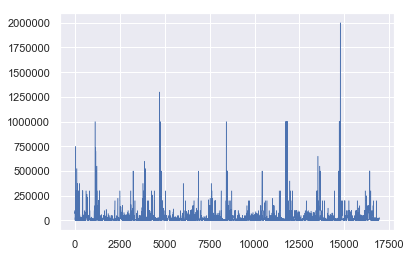

In [10]:
df['Order_Demand'].plot(linewidth=0.5)

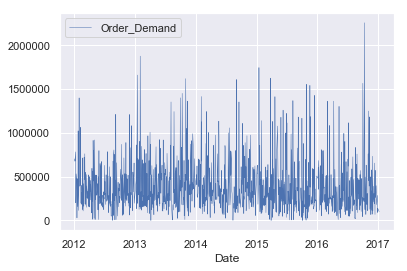

In [29]:
daily_orders = df.groupby(df['Date'].dt.date).sum()
daily_orders.plot(linewidth=0.5)

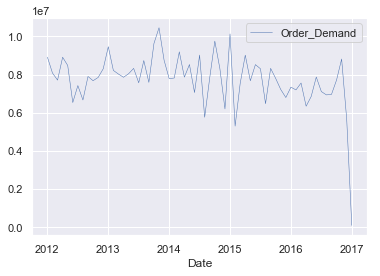

In [12]:
period = df.Date.dt.to_period("M")
monthly_orders = df.groupby(period).sum()
monthly_orders.plot(linewidth=0.5)

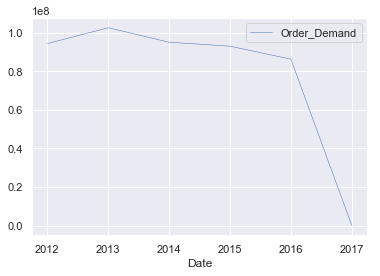

In [13]:
period = df.Date.dt.to_period("Y")
yearly_orders = df.groupby(period).sum()
yearly_orders.plot(linewidth=0.5)

So there are multiple orders per day although some days have zero orders. It happens to be quite noisely on the day-by-day level. Monthly and yearly trends are significantly better.

## Model Building
### Testing
I'll use the year 2016 as a testing set and 2012 to 2015 as the training set. This will give a rough 80-20 train-test split for some model comparisons.

In [38]:
#Using weekly orders as minimum window otherwise we have negative orders
weekly_orders = df.groupby(pd.Grouper(key='Date', freq='W-MON')).sum().reset_index()

training = weekly_orders.loc[weekly_orders['Date'] <
                            pd.to_datetime('2016-1-1').date()]
testing = weekly_orders.loc[weekly_orders['Date'] >
                            pd.to_datetime('2015-12-31').date()]

C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.



### Prophet

Prophet is something Facebook published for time series forecasting and so I'll start with that.

In [39]:
from fbprophet import Prophet as pt

prophet_model = pt(interval_width=0.95)

In [40]:
#required specific column headings
training_renamed = training.rename(columns={'Date': 'ds', 'Order_Demand': 'y'})
testing_renamed = testing.rename(columns={'Date': 'ds', 'Order_Demand': 'y'})

prophet_model.fit(training_renamed)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
testing_dates = prophet_model.make_future_dataframe(periods=16, freq='MS')

testing_dates.tail()

,ds
219,2016-12-01
220,2017-01-01
221,2017-02-01
222,2017-03-01
223,2017-04-01


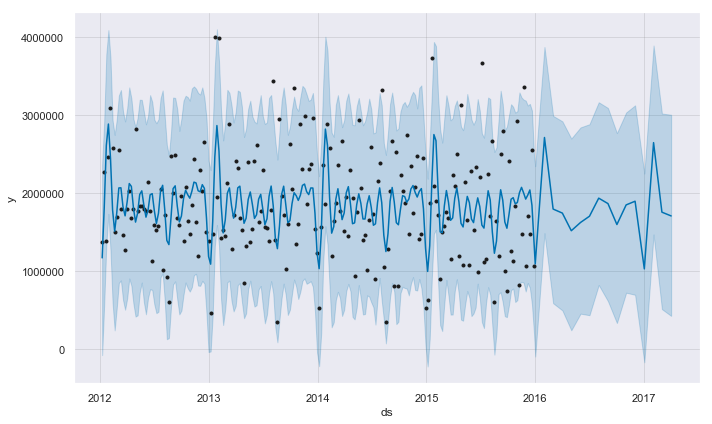

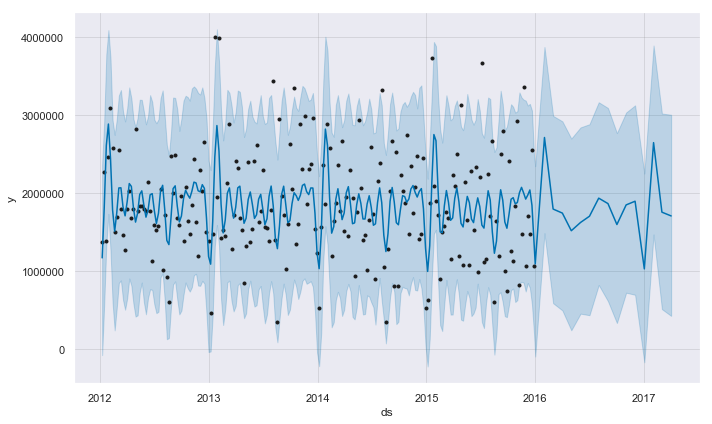

In [42]:
forecast = prophet_model.predict(testing_dates)
prophet_model.plot(forecast, uncertainty=True)

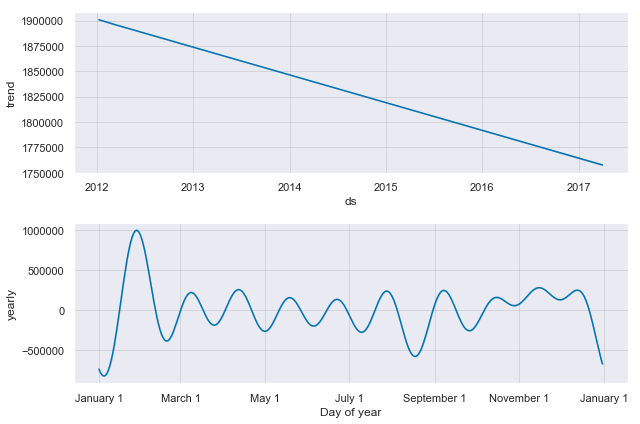

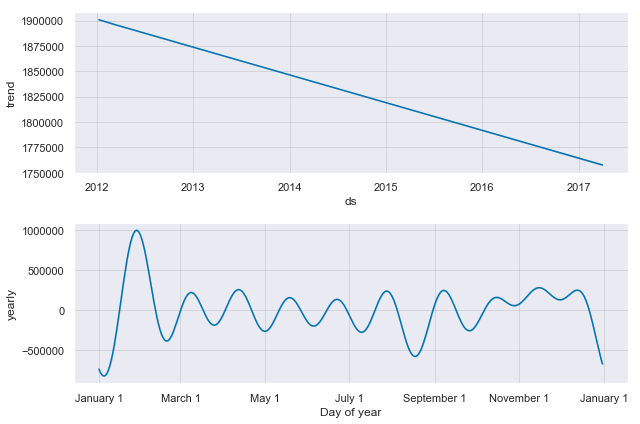

In [43]:
prophet_model.plot_components(forecast)